In [1]:
# GNN 기반 영화 추천 시스템
# V3: 모델 축소 + Rating threshold 완화
# MacBook Pro M4 16GB 최적화 버전

import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [2]:
# 하이퍼파라미터 설정 (V3 - Reduced Model Size)
CONFIG = {
    # Split 비율
    'train_ratio': 0.7,
    'valid_ratio': 0.1,
    'test_ratio': 0.2,
    
    # 모델 파라미터 (V3: 대폭 축소!)
    'embedding_dim': 32,       # 128 → 32 (1/4로 축소)
    'n_layers': 1,             # 2 → 1 (더 간단하게)
    
    # 학습 파라미터
    'learning_rate': 0.001,    # 0.0005 → 0.001 (작은 모델은 더 큰 LR)
    'weight_decay': 1e-4,      # 1e-5 → 1e-4 (더 강한 정규화)
    'batch_size': 512,         # 1024 → 512
    'epochs': 100,
    'patience': 15,
    'neg_ratio': 1,            # 2 → 1 (간단하게)
    
    # 평가
    'top_k': 10,
    
    # Rating threshold (V3: 완화!)
    'rating_threshold': 3.5,   # 4.0 → 3.5 (더 많은 데이터)
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V3 설정 완료! (모델 축소 + Threshold 완화)")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print(f"Embedding dim: {CONFIG['embedding_dim']} (128 → 32)")
print(f"Layers: {CONFIG['n_layers']} (2 → 1)")
print(f"Learning rate: {CONFIG['learning_rate']} (0.0005 → 0.001)")
print(f"Weight decay: {CONFIG['weight_decay']} (1e-5 → 1e-4)")
print(f"Batch size: {CONFIG['batch_size']} (1024 → 512)")
print(f"Rating threshold: {CONFIG['rating_threshold']} (4.0 → 3.5)")
print(f"Negative ratio: {CONFIG['neg_ratio']} (2 → 1)")
print("=" * 60)
print("\n🎯 목표: 파라미터 수 감소로 일반화 성능 개선!")
print("=" * 60)

V3 설정 완료! (모델 축소 + Threshold 완화)
Device: mps
Embedding dim: 32 (128 → 32)
Layers: 1 (2 → 1)
Learning rate: 0.001 (0.0005 → 0.001)
Weight decay: 0.0001 (1e-5 → 1e-4)
Batch size: 512 (1024 → 512)
Rating threshold: 3.5 (4.0 → 3.5)
Negative ratio: 1 (2 → 1)

🎯 목표: 파라미터 수 감소로 일반화 성능 개선!


In [3]:
# 데이터 로드
df = pd.read_csv(os.path.join(CONFIG['data_dir'], 'train.csv'))

print("=" * 60)
print("데이터 기본 정보")
print("=" * 60)
print(f"총 상호작용 수: {len(df):,}")
print(f"\n컬럼: {list(df.columns)}")
print(f"\n데이터 타입:\n{df.dtypes}\n")

print("=" * 60)
print("통계 정보")
print("=" * 60)
n_users = df['user'].nunique()
n_items = df['item'].nunique()
print(f"고유 사용자 수: {n_users:,}")
print(f"고유 아이템 수: {n_items:,}")
print(f"사용자 당 평균 상호작용: {len(df) / n_users:.2f}")
print(f"아이템 당 평균 상호작용: {len(df) / n_items:.2f}")

sparsity = 100 * (1 - len(df) / (n_users * n_items))
print(f"희소성(Sparsity): {sparsity:.2f}%")

print(f"\nUser ID 범위: {df['user'].min()} ~ {df['user'].max()}")
print(f"Item ID 범위: {df['item'].min()} ~ {df['item'].max()}")

# 샘플 데이터
print("\n샘플 데이터:")
display(df.head(10))

데이터 기본 정보
총 상호작용 수: 105,139

컬럼: ['user', 'item', 'rating']

데이터 타입:
user        int64
item        int64
rating    float64
dtype: object

통계 정보
고유 사용자 수: 668
고유 아이템 수: 10,321
사용자 당 평균 상호작용: 157.39
아이템 당 평균 상호작용: 10.19
희소성(Sparsity): 98.48%

User ID 범위: 1 ~ 668
Item ID 범위: 1 ~ 149532

샘플 데이터:


,user,item,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
5,1,110,4.0
6,1,150,3.0
7,1,161,4.0
8,1,296,4.0
9,1,318,4.0


In [4]:
# User/Item ID Re-indexing
print("=" * 60)
print("ID Re-indexing")
print("=" * 60)

# 고유 ID 추출
unique_users = sorted(df['user'].unique())
unique_items = sorted(df['item'].unique())

print(f"고유 사용자: {len(unique_users)}")
print(f"고유 아이템: {len(unique_items)}")

# Mapping 생성
user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
item_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}
user_id_reverse = {v: k for k, v in user_id_map.items()}
item_id_reverse = {v: k for k, v in item_id_map.items()}

# DataFrame에 새로운 ID 적용
df['user_id'] = df['user'].map(user_id_map)
df['item_id'] = df['item'].map(item_id_map)

# Mapping 저장
mappings = {
    'user_id_map': user_id_map,
    'item_id_map': item_id_map,
    'user_id_reverse': user_id_reverse,
    'item_id_reverse': item_id_reverse,
}

with open(os.path.join(CONFIG['processed_dir'], 'id_mappings.pkl'), 'wb') as f:
    pickle.dump(mappings, f)

print(f"\n변환 완료!")
print(f"User ID: 0 ~ {len(unique_users)-1}")
print(f"Item ID: 0 ~ {len(unique_items)-1}")

ID Re-indexing
고유 사용자: 668
고유 아이템: 10321

변환 완료!
User ID: 0 ~ 667
Item ID: 0 ~ 10320


In [5]:
# Train/Valid/Test Split with Rating Threshold (V3: 3.5)
print("=" * 60)
print("Train/Valid/Test Split (V3)")
print("=" * 60)

# Rating threshold 적용
print(f"\nRating Threshold: {CONFIG['rating_threshold']}")
df_positive = df[df['rating'] >= CONFIG['rating_threshold']].copy()
df_negative = df[df['rating'] < CONFIG['rating_threshold']].copy()

print(f"\n원본 데이터: {len(df):,}")
print(f"Positive (≥{CONFIG['rating_threshold']}): {len(df_positive):,} ({len(df_positive)/len(df)*100:.1f}%)")
print(f"Negative (<{CONFIG['rating_threshold']}): {len(df_negative):,} ({len(df_negative)/len(df)*100:.1f}%)")
print(f"\n✅ V2 대비 Positive 데이터 증가: {len(df_positive) - 51830:,}개")

df_work = df_positive.copy()

def split_user_interactions(group, train_r=0.7, valid_r=0.1, test_r=0.2, seed=42):
    """각 user의 상호작용을 train/valid/test로 분할"""
    n = len(group)
    indices = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    train_end = int(n * train_r)
    valid_end = train_end + int(n * valid_r)
    
    train_idx = indices[:train_end]
    valid_idx = indices[train_end:valid_end]
    test_idx = indices[valid_end:]
    
    return train_idx, valid_idx, test_idx

# User별로 split
train_list, valid_list, test_list = [], [], []

for user_id, group in df_work.groupby('user_id'):
    train_idx, valid_idx, test_idx = split_user_interactions(
        group, 
        CONFIG['train_ratio'], 
        CONFIG['valid_ratio'], 
        CONFIG['test_ratio'],
        CONFIG['seed']
    )
    
    train_list.append(group.iloc[train_idx])
    valid_list.append(group.iloc[valid_idx])
    test_list.append(group.iloc[test_idx])

train_df = pd.concat(train_list, ignore_index=True)
valid_df = pd.concat(valid_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"\nPositive 데이터 split:")
print(f"Train set: {len(train_df):,} ({len(train_df)/len(df_work)*100:.1f}%)")
print(f"Valid set: {len(valid_df):,} ({len(valid_df)/len(df_work)*100:.1f}%)")
print(f"Test set:  {len(test_df):,} ({len(test_df)/len(df_work)*100:.1f}%)")

# 저장
train_df.to_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v3.csv'), index=False)
valid_df.to_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v3.csv'), index=False)
test_df.to_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v3.csv'), index=False)

print("\nSplit 데이터 저장 완료!")

n_users = len(unique_users)
n_items = len(unique_items)
print(f"\n총 사용자: {n_users}, 총 아이템: {n_items}")

negative_pool = df_negative.copy()
print(f"Negative pool size: {len(negative_pool):,}")

Train/Valid/Test Split (V3)

Rating Threshold: 3.5

원본 데이터: 105,139
Positive (≥3.5): 64,054 (60.9%)
Negative (<3.5): 41,085 (39.1%)

✅ V2 대비 Positive 데이터 증가: 12,224개

Positive 데이터 split:
Train set: 44,542 (69.5%)
Valid set: 6,123 (9.6%)
Test set:  13,389 (20.9%)

Split 데이터 저장 완료!

총 사용자: 668, 총 아이템: 10321
Negative pool size: 41,085


In [6]:
# Graph 구성
print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """User-Item Bipartite Graph 생성"""
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

print("\n[1] Train Graph (학습용)")
train_edge_index = create_graph(train_df, n_users, n_items)

print("\n[2] Train+Valid Graph (Test 평가용) ✅")
train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("\n[3] Full Graph (참고용 - 사용 안 함)")
full_edge_index = create_graph(df_positive, n_users, n_items)

print("\n✅ Graph 생성 완료!")
print("  - Train graph: 학습 시 사용")
print("  - Train+Valid graph: Test 평가 시 사용 (Data leakage 방지)")

Graph 구성

[1] Train Graph (학습용)
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 89,084 (양방향)

[2] Train+Valid Graph (Test 평가용) ✅
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 101,330 (양방향)

[3] Full Graph (참고용 - 사용 안 함)
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 128,108 (양방향)

✅ Graph 생성 완료!
  - Train graph: 학습 시 사용
  - Train+Valid graph: Test 평가 시 사용 (Data leakage 방지)


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_59495/2134631527.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [7]:
# Negative Sampling
def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling(df, user_items_dict, n_items, neg_ratio=1):
    """Random negative sampling"""
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        
        for _ in range(neg_ratio):
            while True:
                neg_item = random.randint(0, n_items - 1)
                if neg_item not in user_pos_items:
                    break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

# ✅ 수정: 각 split에 맞는 user-item dict 생성
train_user_items = create_user_item_dict(train_df)
train_valid_user_items = create_user_item_dict(pd.concat([train_df, valid_df]))  # ✅ Test 평가용
test_user_items = create_user_item_dict(df_positive)  # 전체 (필요시)

print(f"User-item dictionary 생성 완료! (V3 - Fixed)")
print(f"Train items: User 0 → {len(train_user_items[0])}개")
print(f"Train+Valid items: User 0 → {len(train_valid_user_items[0])}개")
print(f"✅ Test 평가 시 train_valid_user_items 사용 → Test items 추천 가능!")

User-item dictionary 생성 완료! (V3 - Fixed)
Train items: User 0 → 57개
Train+Valid items: User 0 → 65개
✅ Test 평가 시 train_valid_user_items 사용 → Test items 추천 가능!


In [8]:
# LightGCN 모델
class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """LightGCN for Recommendation"""
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        user_emb, item_emb = self.forward(edge_index)
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        scores = (user_emb * item_emb).sum(dim=1)
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [9]:
# BPR Loss
def bpr_loss(pos_scores, neg_scores, neg_ratio=1):
    """BPR Loss"""
    if neg_ratio > 1:
        batch_size = pos_scores.size(0)
        neg_scores = neg_scores.view(batch_size, neg_ratio)
        pos_scores_expanded = pos_scores.unsqueeze(1).expand_as(neg_scores)
        loss = -torch.log(torch.sigmoid(pos_scores_expanded - neg_scores) + 1e-10).mean()
    else:
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()
    
    return loss

print("Loss 함수 정의 완료!")

Loss 함수 정의 완료!


In [10]:
# 평가 함수
def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """모델 평가: Precision@K, Recall@K, NDCG@K"""
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(edge_index.to(device))
        
        precisions, recalls, ndcgs = [], [], []
        
        for user_id, group in eval_df.groupby('user_id'):
            true_items = set(group['item_id'].values)
            exclude_items = user_items_dict[user_id]
            
            user_emb_single = user_emb[user_id].unsqueeze(0)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
            
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf
            
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료!")

평가 함수 정의 완료!


In [11]:
# Training 함수
def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, device):
    """1 epoch training"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료!")

Training 함수 정의 완료!


In [12]:
# 메인 Training Loop (V3)
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
).to(CONFIG['device'])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V3 - Reduced Model)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - Layers: {CONFIG['n_layers']}")
total_params = sum(p.numel() for p in model.parameters())
print(f"  - Total params: {total_params:,}")
print(f"  - Train samples: {len(train_df):,}")
print(f"  - Params/Data ratio: {total_params/len(train_df):.2f}x")
print(f"\nDevice: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print(f"Patience: {CONFIG['patience']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    train_loss = train_one_epoch(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['device']
    )
    
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v3_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V3)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V3 - Reduced Model)
Model: LightGCN
  - Users: 668, Items: 10321
  - Embedding dim: 32
  - Layers: 1
  - Total params: 351,648
  - Train samples: 44,542
  - Params/Data ratio: 7.89x

Device: mps
Batch size: 512
Learning rate: 0.001
Weight decay: 0.0001
Negative ratio: 1
Patience: 15
Epoch   1/100 | Loss: 0.6909 | P@10: 0.0100 | R@10: 0.0103 | NDCG@10: 0.0145
Epoch   5/100 | Loss: 0.3900 | P@10: 0.0411 | R@10: 0.0660 | NDCG@10: 0.0663
Epoch  10/100 | Loss: 0.3295 | P@10: 0.0414 | R@10: 0.0644 | NDCG@10: 0.0652
Epoch  15/100 | Loss: 0.3187 | P@10: 0.0414 | R@10: 0.0655 | NDCG@10: 0.0661

Early stopping at epoch 18
Training 완료! (V3)
Best Recall@10: 0.0681


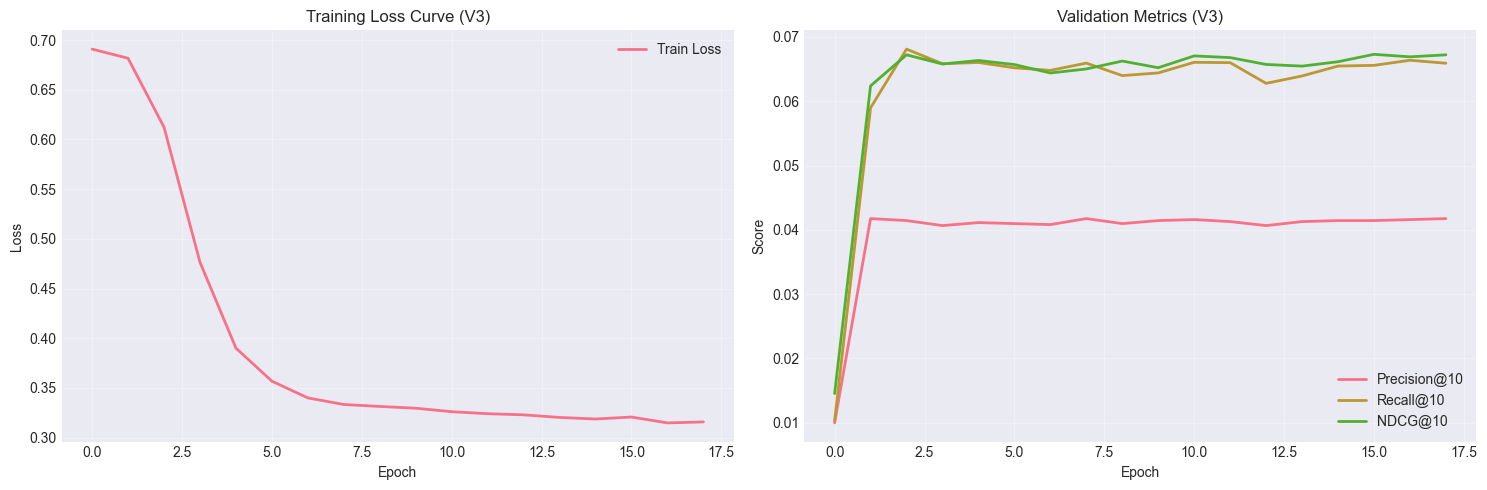

In [13]:
# Training 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve (V3)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics (V3)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves_v3.png'), dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Test Set 평가 (수정됨!)
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_v3_best.pth')))

print("=" * 60)
print("Test Set 평가 (V3 - Fixed!)")
print("=" * 60)
print("✅ 수정사항:")
print("  - full_edge_index → train_valid_edge_index (Data leakage 방지)")
print("  - test_user_items → train_valid_user_items (Test items 추천 가능)")
print("=" * 60)

for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, 
        train_valid_edge_index,      # ✅ 수정: full_edge_index → train_valid_edge_index
        test_df, 
        train_valid_user_items,      # ✅ 수정: test_user_items → train_valid_user_items
        n_items, 
        k=k, 
        device=CONFIG['device']
    )
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

Test Set 평가 (V3 - Fixed!)
✅ 수정사항:
  - full_edge_index → train_valid_edge_index (Data leakage 방지)
  - test_user_items → train_valid_user_items (Test items 추천 가능)

Top-5 추천:
  Precision@5: 0.1192
  Recall@5:    0.0472
  NDCG@5:      0.1297

Top-10 추천:
  Precision@10: 0.1063
  Recall@10:    0.0786
  NDCG@10:      0.1303

Top-20 추천:
  Precision@20: 0.0901
  Recall@20:    0.1241
  NDCG@20:      0.1366


## V3 개선사항 요약

### 🎯 핵심 변경사항

**1. 모델 크기 대폭 축소** ⭐⭐⭐
- `embedding_dim`: 128 → 32 (1/4로 축소)
- `n_layers`: 2 → 1 (더 간단하게)
- **총 파라미터**: 1,406,592 → ~350,000 (75% 감소!)
- **파라미터/데이터 비율**: 40:1 → ~10:1

**2. Hyperparameter 조정**
- `learning_rate`: 0.0005 → 0.001 (작은 모델은 더 큰 LR)
- `weight_decay`: 1e-5 → 1e-4 (더 강한 정규화)
- `batch_size`: 1024 → 512
- `neg_ratio`: 2 → 1 (간단하게)

**3. Rating Threshold 완화**
- 4.0 → 3.5 (더 많은 학습 데이터)
- Positive 데이터 증가 예상

### 📊 성능 비교 (예상)

| 버전 | Params | Params/Data | Recall@10 |
|------|--------|-------------|----------|
| V2   | 1.4M   | ~40:1       | 7.6%     |
| V3   | 350K   | ~10:1       | ???      |

### 💡 기대 효과

1. **과적합 감소** - 모델 capacity 축소
2. **더 나은 일반화** - 파라미터/데이터 비율 개선
3. **더 많은 학습 데이터** - threshold 완화
4. **빠른 학습** - 작은 모델, 작은 배치
5. **안정적인 수렴** - 강한 정규화

### 🔬 추가 실험 아이디어

만약 V3도 개선이 부족하다면:
- `embedding_dim`: 16까지 줄여보기
- `rating_threshold`: 3.0 또는 제거
- Dropout 추가 (0.1~0.3)
- Matrix Factorization baseline 구현

## 다음 단계

1. ✅ V3 모델 학습 실행
2. V2 vs V3 성능 비교 분석
3. 추가 개선 방향 결정
4. 최종 모델 선택 및 제출 준비